In [1]:
# Import libraries for data processing and modeling
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from matplotlib import pyplot
import shap
from sklearn.metrics import accuracy_score
import os

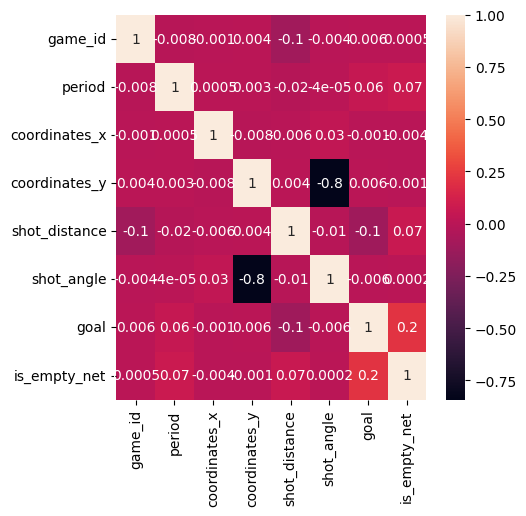

In [2]:
# Load the data
def load_data(path):
    df = pd.read_csv(path) # Path to the result of Feature Engineering 1 data
    return df

def analyze_data(df):
    # Analyzing correlation between all the features using heatmap
    corr = df.corr()
    plt.figure(figsize=(5,5))
    sns.heatmap(corr, annot=True, fmt='.1g')
    plt.show()  

# Add the path of the data of feature engineering 1 data
df = load_data('D:/NHLPro/data/df_all_season.csv') 
df = df[['game_id','period','coordinates_x','coordinates_y','shot_distance','shot_angle','goal','is_empty_net']]
analyze_data(df)

## 5.1 Training XGBoost Classifier

##### 5.1.1 Training XGBoost Classifier with default parameters with ROC AUC as evaluation metric

In [3]:
def XGBoost1(df):
    # XGBoost on distance and angle
    X = df[['shot_distance','shot_angle']].astype(np.float32)
    y = df['goal']

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

    xgb1 = xgboost.XGBClassifier()
    xgb_dist_angle = xgb1.fit(x_train, y_train)

    y_pred = xgb_dist_angle.predict(x_val)

    # Calculate score
    xgb_dist_angle_score = xgb_dist_angle.score(x_val, y_val)
    print('XGBoost score on distance and angle: ', xgb_dist_angle_score)

    # Classification report
    xgb_dist_angle_report = classification_report(y_val, y_pred)
    print('XGBoost classification report on distance and angle: ', xgb_dist_angle_report)

    # Confusion matrix
    xgb_dist_angle_confusion = confusion_matrix(y_val, y_pred)
    print('XGBoost confusion matrix on distance and angle: ', xgb_dist_angle_confusion)

    return xgb_dist_angle, x_val,y_val

In [4]:
def plot_roc_curve(model,x_val,y_val,label):
    # ROC curve
    y_pred_proba = model.predict_proba(x_val)[:,1]
    xgb_dist_angle_roc_auc = roc_auc_score(y_val, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=label+'(area = %0.2f)' % xgb_dist_angle_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('Log_ROC')
    plt.show()

##### 5.1.2 Goal Rate as a function of shot probability model percentile

In [5]:
# Shot probability model percentile based on distance and angle
def shot_probability(model, x_val):
    xgb_probability = model.predict_proba(x_val)[:,1]
    x_axis = np.arange(len(xgb_probability))[::-1]*100/len(xgb_probability)
    y_axis = np.sort(xgb_probability)[::-1]
    plt.plot(x_axis, y_axis)
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal Rate')
    plt.title('Shot probability model percentile based on distance and angle')
    plt.show()



##### 5.1.3 The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.

In [6]:
def cumulative_probability(model, x_val):
    xgb_probability = model.predict_proba(x_val)[:,1]
    x_axis = np.arange(len(xgb_probability))[::-1]*100/len(xgb_probability)
    y_axis = np.sort(xgb_probability)[::-1]
    y_axis_cum = np.cumsum(y_axis)/np.sum(y_axis)
    plt.plot(x_axis, y_axis_cum)
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Cumulative proportion of goals')
    plt.title('Cumulative probability of goals')
    plt.show()



XGBoost score on distance and angle:  0.9058229255214805
XGBoost classification report on distance and angle:                precision    recall  f1-score   support

           0       0.91      1.00      0.95     55414
           1       0.46      0.00      0.01      5758

    accuracy                           0.91     61172
   macro avg       0.68      0.50      0.48     61172
weighted avg       0.86      0.91      0.86     61172

XGBoost confusion matrix on distance and angle:  [[55393    21]
 [ 5740    18]]


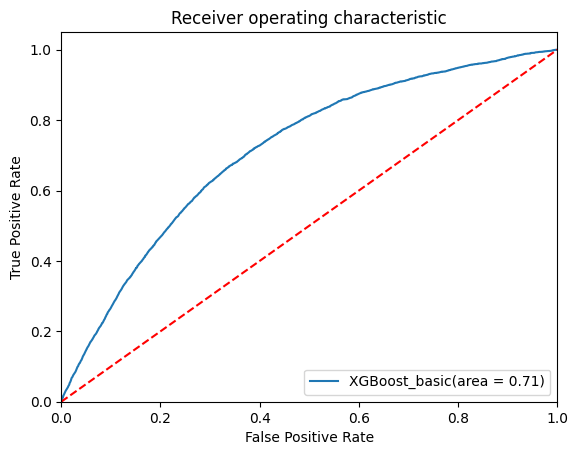

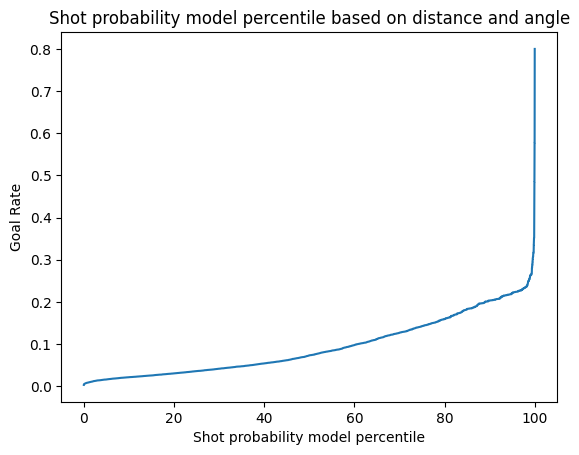

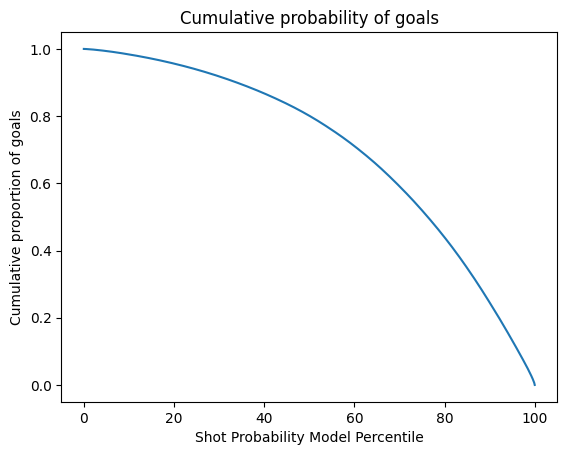

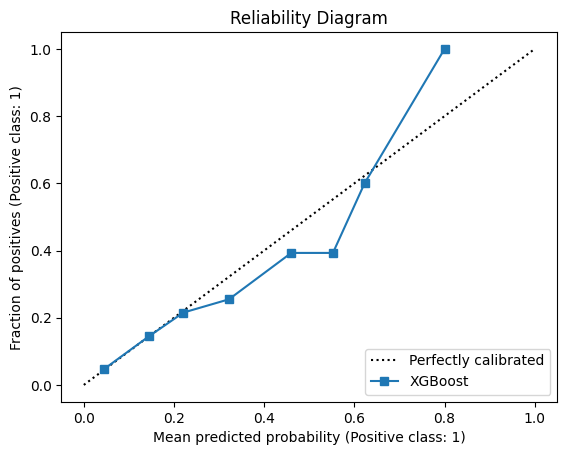

In [8]:
# Calibration plot using CalibrationDisplay
def calibration_plot(model, x_val, y_val):
    CalibrationDisplay.from_estimator(model, x_val, y_val, n_bins=10, name='XGBoost', ax=None)
    plt.title('Reliability Diagram')
    plt.show()


xgb1, x_val, y_val = XGBoost1(df)
plot_roc_curve(xgb1, x_val, y_val,"XGBoost_basic")
shot_probability(xgb1, x_val)
cumulative_probability(xgb1, x_val)
calibration_plot(xgb1, x_val, y_val)


## 5.2 Train XGBoost with all features

In [11]:
df1 = load_data('D:/NHLPro/data/M2_added_features_all.csv') # Path to the result of Feature Engineering 2 data
df1.head()

,game_id,period,period_time,coordinates_x,coordinates_y,shot_distance,shot_angle,secondary_type,goal,last_event_type,last_event_coordinates_x,last_event_coordinates_y,time_from_last_event(s),distance_from_last_event,rebound,angle_change,speed
0,2015020001,1.0,00:51,-55.0,6.0,34.525353,-10.007951,Wrist Shot,0,Hit,94.0,-34.0,11.0,154.275727,False,0.000000,14.025066
1,2015020001,1.0,01:05,-79.0,0.0,10.000000,0.000000,Snap Shot,0,Giveaway,-37.0,-28.0,7.0,50.477718,False,0.000000,7.211103
2,2015020001,1.0,01:06,-75.0,-1.0,14.035669,4.085588,Snap Shot,0,Shot,-79.0,0.0,1.0,4.123106,True,4.085588,4.123106
3,2015020001,1.0,01:53,-55.0,-36.0,49.517674,46.636455,Wrist Shot,0,Hit,-91.0,35.0,18.0,79.605276,False,0.000000,4.422515
4,2015020001,1.0,02:37,-61.0,-1.0,28.017851,2.045401,Tip-In,0,Faceoff,-69.0,-22.0,5.0,22.472205,False,0.000000,4.494441


In [12]:
# Load the data
df1 = load_data('D:/NHLPro/data/M2_added_features_all.csv') # Path to the result of Feature Engineering 2 data

# Data Preprocessing
def preprocess_data(df):
    # Convert rebound to 0 and 1 instead of True and False
    df['rebound'] = df['rebound'].astype(int)
    # Rearranging columns to make it easier to process data
    df=df[['game_id','period','period_time','coordinates_x','coordinates_y','shot_distance','shot_angle','secondary_type','last_event_type','time_from_last_event(s)','distance_from_last_event','rebound','angle_change','speed','last_event_coordinates_x','last_event_coordinates_y','goal']]
    # Convert period_time to seconds
    df['period_time'] = df['period_time'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
    # Convert secondary_type and last_event_type to numeric
    # df['secondary_type'] = df['secondary_type'].astype('category').cat.codes
    # df['last_event_type'] = df['last_event_type'].astype('category').cat.codes
    # Convert secondary_type and last_event_type to dummy variables
    df = pd.get_dummies(df, columns=['secondary_type','last_event_type'], drop_first=True)
    
    return df

df1 = preprocess_data(df1)



In [13]:
# XGBoost on all features except goal
def XGBoost2(df):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Hyper parameter tuning
    # Create the parameter grid based on the results of random search
    param_grid = {
        'max_depth': [3, 4, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5,1,1.5,2,5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 500, 1000],

    }

    # Create a based model
    xgb = XGBClassifier(n_estimators=1000, objective='binary:logistic', silent=True, nthread=1)
    stratifiedSearch = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    randomSearch = RandomizedSearchCV(estimator = xgb, param_distributions = param_grid, n_iter = 3, cv = stratifiedSearch, verbose=3, random_state=42, n_jobs = 4)
    
    # Fit the random search model
    randomSearch.fit(X_train, y_train)

    # Print best parameters and best score from random search 
    print("Best parameters from random search: ", randomSearch.best_params_)
    print("Best score from random search: ", randomSearch.best_score_)
    print("Best estimator from random search: ", randomSearch.best_estimator_)
    print("Best index from random search: ", randomSearch.best_index_)

    

In [14]:
XGBoost2(df1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[20:12:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Best parameters from random search:  {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.8}
Best score from random search:  0.9807223892442954
Best estimator from random search:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delt

In [33]:
def XGB_with_best_estimator_all_feature(X_train, X_test, y_train, y_test):
    # Training the XGBoost model on the Training set with best parameters from random search

    # X = df.iloc[:,:-1]
    # y = df.iloc[:,-1]

    # # Split the data into train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model on the trainng data
    xgb = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=10,
              monotone_constraints='()', n_estimators=500, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto')

    xgb.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = xgb.predict(X_test)

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix, accuracy_score
    cm = confusion_matrix(y_test, y_pred)
    print("The confusion matrix is : ",cm)

    # Accuracy
    print("The accuracy score is: ",accuracy_score(y_test, y_pred))

    # Making classification report 
    from sklearn.metrics import classification_report
    print("The classification report: ",classification_report(y_test, y_pred))

    return xgb, X_test, y_test
    
    

In [34]:
# Split the data into test and train
X = df1.iloc[:,:-1]
y = df1.iloc[:,-1]
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb2, X_test2, y_test2 = XGB_with_best_estimator_all_feature(X_train, X_test, y_train, y_test) 

The confusion matrix is :  [[56822   278]
 [  849  3223]]
The accuracy score is:  0.9815765382854901
The classification report:                precision    recall  f1-score   support

           0       0.99      1.00      0.99     57100
           1       0.92      0.79      0.85      4072

    accuracy                           0.98     61172
   macro avg       0.95      0.89      0.92     61172
weighted avg       0.98      0.98      0.98     61172



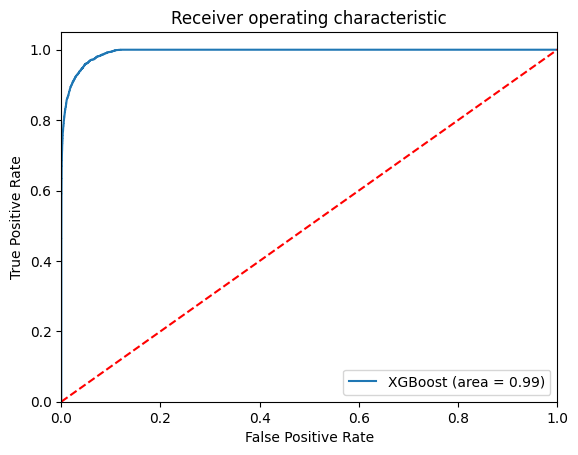

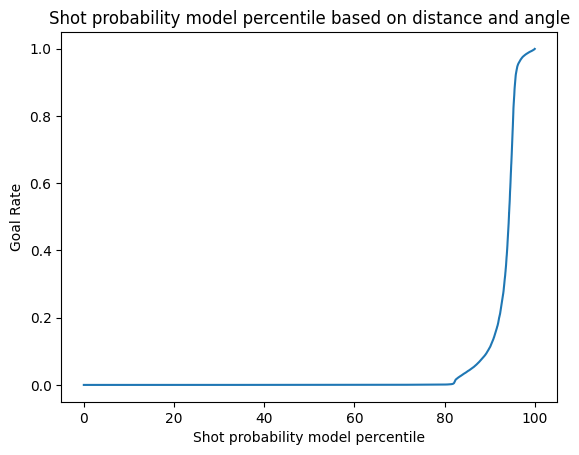

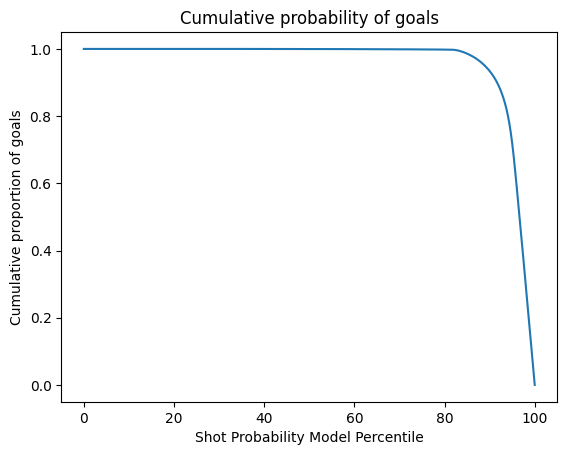

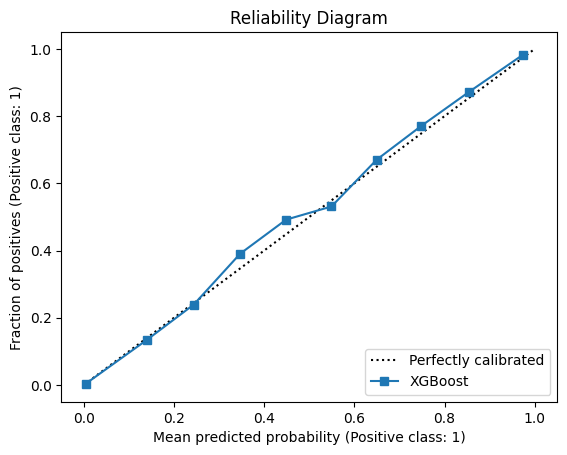

In [36]:
plot_roc_curve(xgb2,X_test2,y_test2)
shot_probability(xgb2, X_test2)
cumulative_probability(xgb2, X_test2)
calibration_plot(xgb2, X_test2, y_test2)

### 5.3.1 Feature Selection using SHAP and then applying XGBoost

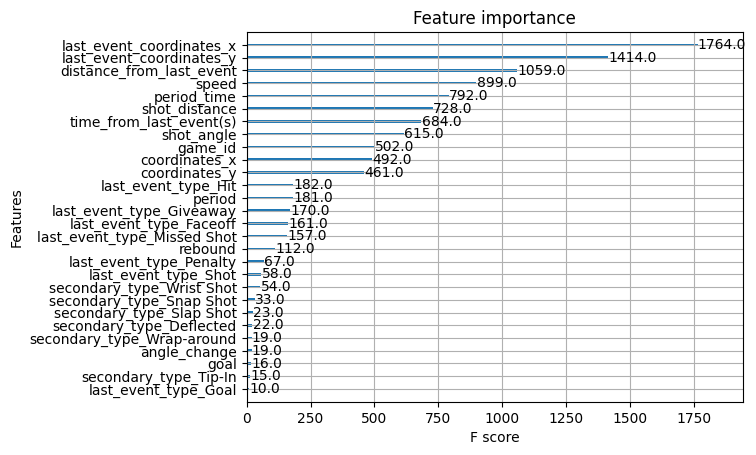

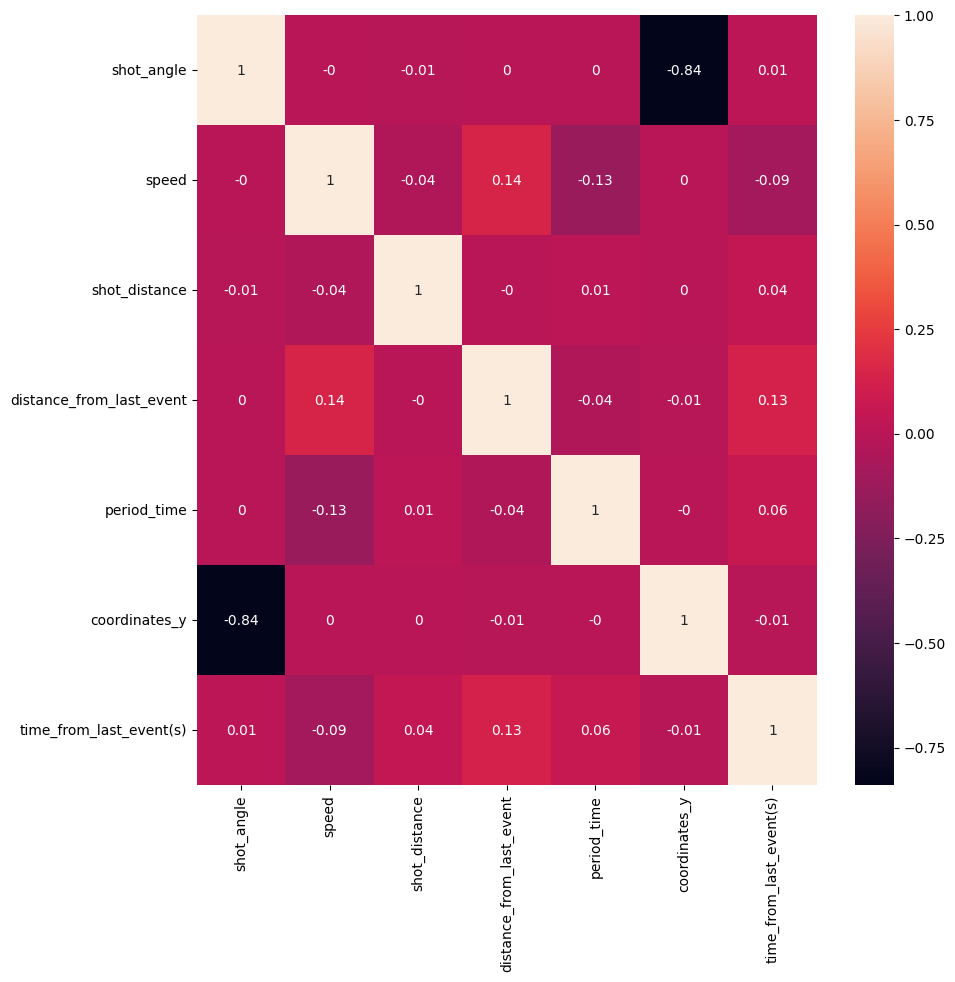

In [37]:
def plot_feature_importance(model):
    # plot feature importance
    plot_importance(model)
    plt.show()

def correlation(df):
    # Create heatmap to show correlation between features
    corr_matrix = df[['shot_angle','speed','shot_distance','distance_from_last_event','period_time','coordinates_y','time_from_last_event(s)']].corr().round(2)

    # Heatmap
    plt.figure(figsize=(10,10))
    sns.heatmap(data=corr_matrix, annot=True)
    plt.show()

plot_feature_importance(xgb2)
correlation(df1)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


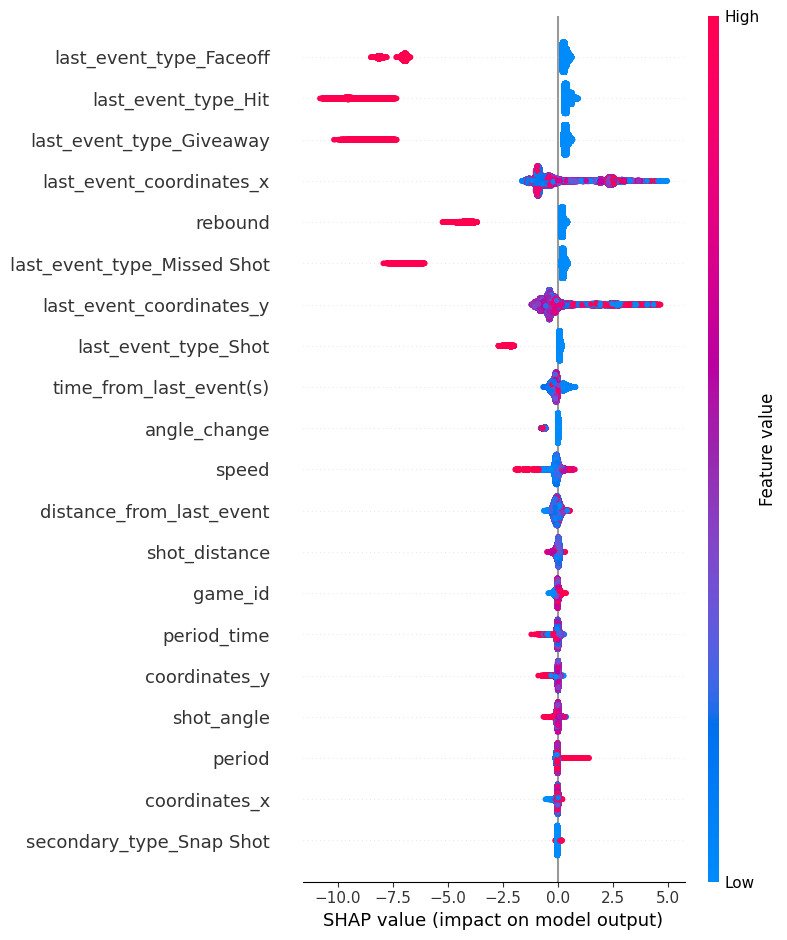

In [38]:
# Explain model predictions using shap library:
def explain_model_prediction(model, X_test):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)

    # Calculate Shap values
    shap_values = explainer.shap_values(X_test)

    # Make plot. Index of [1] is explained in text below.
    shap.summary_plot(shap_values, X_test)

explain_model_prediction(xgb2, X_test2)


In [20]:
# Lets take 7 most important features and train the model again
def XGBoost3(df):
    # Training the XGBoost model on the Training set

    X = df[['last_event_coordinates_x','last_event_coordinates_y','distance_from_last_event','speed','period_time','shot_distance','shot_angle']]
    y = df.iloc[:,-1]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a parameter grid: map the parameter names to the values that should be searched
    param_grid = {"max_depth": [3, 5, 7],
                    "learning_rate" : [0.01, 0.05, 0.1],
                    "gamma": [0.5, 1, 1.5],
                    "min_child_weight": [1, 5, 10],
                    "colsample_bytree": [0.6, 0.8, 1.0],
                    "subsample": [0.6, 0.8, 1.0],
                    "reg_alpha": [0, 0.5, 1],
                    "reg_lambda": [1, 1.5, 2],
                    "scale_pos_weight": [1, 3, 5]}

    # Create a based model
    xgb3 = XGBClassifier(n_estimators=1000, objective='binary:logistic', silent=True, nthread=1)
    stratifiedSearch = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    randomSearch = RandomizedSearchCV(estimator = xgb3, param_distributions = param_grid, n_iter = 3, cv = stratifiedSearch, verbose=3, random_state=42, n_jobs = 4)
    
    # Fit the random search model
    randomSearch.fit(X_train, y_train)

    # Print best parameters and best score from random search 
    print("Best parameters from random search: ", randomSearch.best_params_)
    print("Best score from random search: ", randomSearch.best_score_)
    print("Best estimator from random search: ", randomSearch.best_estimator_)
    print("Best index from random search: ", randomSearch.best_index_)

In [21]:
XGBoost3(df1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[20:33:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Best parameters from random search:  {'subsample': 0.6, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 1.0}
Best score from random search:  0.9325017979722435
Best estimator from random search:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshol

In [22]:
# Training the XGBoost model on the Training set with best parameters from random search
def XGB_with_best_estimator_7_feature(df):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    xgb3 = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto')


    xgb3.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = xgb3.predict(X_test)

    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix: ", cm)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy Score: ", accuracy)

    # Making classification report 
    print("The classification report: ",classification_report(y_test, y_pred))

    return xgb3, X_test, y_test


In [23]:
xgb3, X_test3, y_test3 = XGB_with_best_estimator_7_feature(df1)

Confusion matrix:  [[56844   256]
 [  879  3193]]
Accuracy Score:  0.9814457594978094
The classification report:                precision    recall  f1-score   support

           0       0.98      1.00      0.99     57100
           1       0.93      0.78      0.85      4072

    accuracy                           0.98     61172
   macro avg       0.96      0.89      0.92     61172
weighted avg       0.98      0.98      0.98     61172



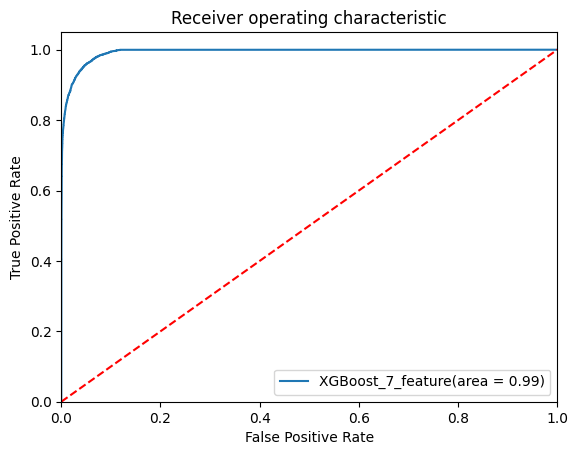

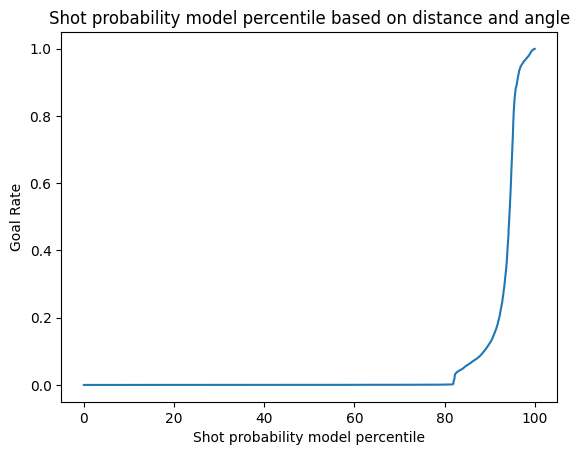

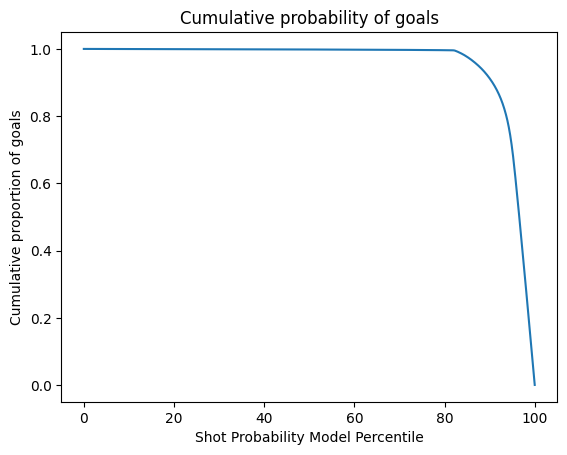

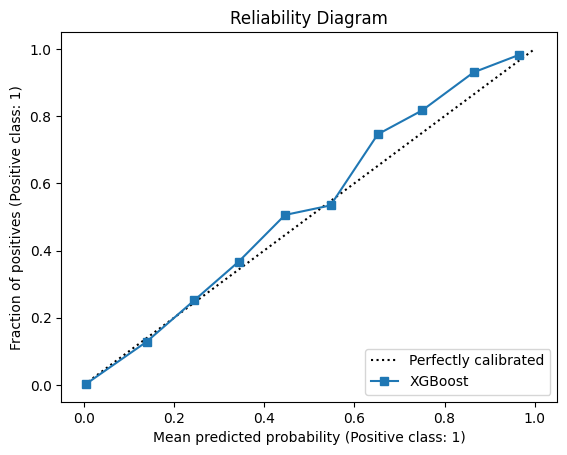

In [25]:
plot_roc_curve(xgb3, X_test3, y_test3,"XGBoost_7_feature")
shot_probability(xgb3, X_test3)
cumulative_probability(xgb3, X_test3)
calibration_plot(xgb3, X_test3, y_test3)